In [10]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import warnings
warnings.filterwarnings('ignore')
import cv2
import matplotlib.pyplot as plt


In [11]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('data/data/')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]



In [12]:
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

train_ids = load_text_ids('train_source_images.txt')
validate_ids = load_text_ids('val_source_images.txt')
test_ids = load_text_ids('test_source_images.txt')

subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)


# Loading and pre processing the data
### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [15]:
import random
import tensorflow as tf
from PIL import Image 

# def load_and_preprocess(img_loc, label):
    
#     def _inner_function(img_loc, label):
        
#         # Convert tensor to native type
#         img_loc_str = img_loc.numpy().decode('utf-8')
#         label_str = label.numpy().decode('utf-8')
        
#         img = Image.open(img_loc_str).convert('RGB')
        
        
#         return img, 1 if label_str=='frost' else 0

#     # Wrap the Python function
#     X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    
#     return X, y

def load_and_preprocess(img_loc, label):
    def _inner_function(img_loc, label):
        img_loc_str = img_loc.numpy().decode('utf-8')
        img = Image.open(img_loc_str).convert('RGB')
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])
        img = img / 255.0
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        return img, label
    
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    X.set_shape([299, 299, 3])
    y.set_shape([])
    
    return X, y


def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)


# (c) Training CNN + MLP

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 297, 297, 32)      896       
                                                                 
 batch_normalization_27 (Ba  (None, 297, 297, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 148, 148, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 148, 148, 32)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 146, 146, 64)      18496     
                                                                 
 batch_normalization_28 (Ba  (None, 146, 146, 64)     

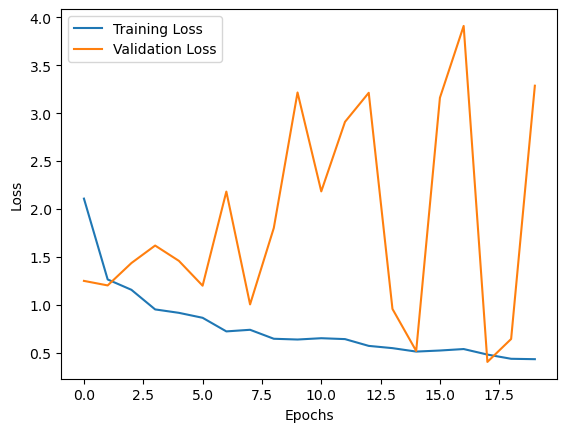

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Create the CNN model
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Flatten layer
model.add(Flatten())

# Dense layer
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(
    tf_dataset_train,
    epochs=20,
    validation_data=tf_dataset_val,
    callbacks=[early_stopping]
)

# Plot training and validation errors vs. epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(tf_dataset_test)

y_pred_binary = (y_pred > 0.5).astype(int)

y_true = tf.concat([label for _, label in tf_dataset_test], axis=0).numpy()

print("Classification Report:")
print(classification_report(y_true, y_pred_binary))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_binary))


401/401 [==============================] - 286s 700ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.11      0.16      4418
           1       0.66      0.90      0.76      8405

    accuracy                           0.62     12823
   macro avg       0.50      0.50      0.46     12823
weighted avg       0.55      0.62      0.55     12823

Confusion Matrix:
[[ 474 3944]
 [ 868 7537]]


# (d) Transfer Learning

In [23]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
import os
import random
import numpy as np
from PIL import Image
from pathlib import Path
from tensorflow.keras.applications.efficientnet import preprocess_input

def load_and_preprocess_transfer_learning(img_loc, label):
    def _inner_function(img_loc, label):
        img_loc_str = img_loc.numpy().decode('utf-8')
        img = Image.open(img_loc_str).convert('RGB')
        img = np.array(img)
        img = tf.image.resize(img, [224, 224])
        img = preprocess_input(img) 
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        return img, label
    
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    X.set_shape([224, 224, 3])
    y.set_shape([])
    
    return X, y

def load_subdir_data_transfer_learning(dir_path, image_size, seed=None):
    """Helper to create a TF dataset from each image subdirectory for transfer learning"""
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path / Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list


tf_data_train_transfer, tf_data_test_transfer, tf_data_val_transfer = [], [], []
tf_dataset_train_transfer, tf_dataset_test_transfer, tf_dataset_val_transfer = [], [], []

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split == 'validate':
        tf_data_val_transfer.extend(load_subdir_data_transfer_learning(full_path, IMAGE_SIZE, SEED))
    elif split == 'train':
        tf_data_train_transfer.extend(load_subdir_data_transfer_learning(full_path, IMAGE_SIZE, SEED))
    elif split == 'test':
        tf_data_test_transfer.extend(load_subdir_data_transfer_learning(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train_transfer)
img_list_transfer, label_list_transfer = zip(*tf_data_train_transfer)
img_list_t_transfer = tf.convert_to_tensor(img_list_transfer)
lb_list_t_transfer = tf.convert_to_tensor(label_list_transfer)

tf_dataset_train_transfer = tf.data.Dataset.from_tensor_slices((img_list_t_transfer, lb_list_t_transfer))
tf_dataset_train_transfer = tf_dataset_train_transfer.map(load_and_preprocess_transfer_learning,
                                                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train_transfer = tf_dataset_train_transfer.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val_transfer)
img_list_transfer, label_list_transfer = zip(*tf_data_val_transfer)
img_list_t_transfer = tf.convert_to_tensor(img_list_transfer)
lb_list_t_transfer = tf.convert_to_tensor(label_list_transfer)

tf_dataset_val_transfer = tf.data.Dataset.from_tensor_slices((img_list_t_transfer, lb_list_t_transfer))
tf_dataset_val_transfer = tf_dataset_val_transfer.map(load_and_preprocess_transfer_learning,
                                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val_transfer = tf_dataset_val_transfer.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test_transfer)
img_list_transfer, label_list_transfer = zip(*tf_data_test_transfer)
img_list_t_transfer = tf.convert_to_tensor(img_list_transfer)
lb_list_t_transfer = tf.convert_to_tensor(label_list_transfer)

tf_dataset_test_transfer = tf.data.Dataset.from_tensor_slices((img_list_t_transfer, lb_list_t_transfer))
tf_dataset_test_transfer = tf_dataset_test_transfer.map(load_and_preprocess_transfer_learning,
                                                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test_transfer = tf_dataset_test_transfer.shuffle(buffer_size=buffer_size).batch(batch_size)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_22 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4050852 (15.45 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________
Epoch 1/20
928/928 [==============================] - 928s 978ms/step - loss: 0.3416 - accuracy: 0.8637 - val_loss: 0.5238 - val_accuracy: 0.747

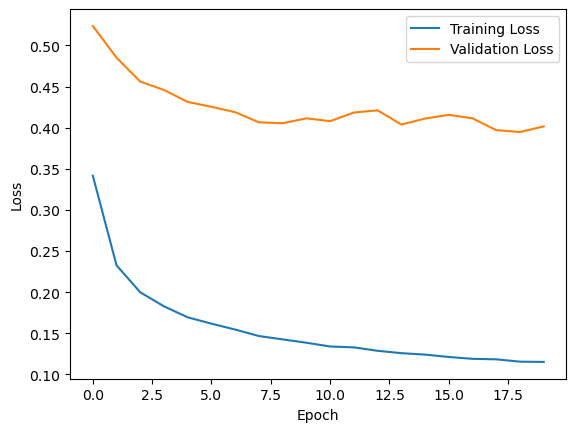

401/401 [==============================] - 330s 823ms/step - loss: 0.2682 - accuracy: 0.9187
Test Loss: 0.26823627948760986, Test Accuracy: 0.9186617732048035


In [24]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid') 
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history = model.fit(
    tf_dataset_train_transfer,
    epochs=20,
    validation_data=tf_dataset_val_transfer,
    callbacks=[early_stopping]
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_loss, test_accuracy = model.evaluate(tf_dataset_test_transfer)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


In [27]:
predictions = model.predict(tf_dataset_test_transfer)

predicted_labels = np.round(predictions).astype(int)

true_labels = np.concatenate([y.numpy() for _, y in tf_dataset_test_transfer], axis=0)

report = classification_report(true_labels, predicted_labels)
print("Classification Report:\n", report)


401/401 [==============================] - 282s 686ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.02      0.04      4418
           1       0.66      0.98      0.79      8405

    accuracy                           0.65     12823
   macro avg       0.51      0.50      0.41     12823
weighted avg       0.55      0.65      0.53     12823



In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def build_transfer_learning_model(base_model):
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))

    for layer in base_model.layers:
        layer.trainable = False

    return model

input_size = (224, 224, 3)

efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_size)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_size)
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=input_size)

efficientnet_transfer_model = build_transfer_learning_model(efficientnet_model)
resnet50_transfer_model = build_transfer_learning_model(resnet50_model)
vgg16_transfer_model = build_transfer_learning_model(vgg16_model)

def compile_model(model):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

efficientnet_transfer_model = compile_model(efficientnet_transfer_model)
resnet50_transfer_model = compile_model(resnet50_transfer_model)
vgg16_transfer_model = compile_model(vgg16_transfer_model)

def train_transfer_learning_model(model, train_data, val_data, epochs=20):
    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        callbacks=[early_stopping]
    )
    
    return model, history

epochs = 20
efficientnet_transfer_model, efficientnet_history = train_transfer_learning_model(
    efficientnet_transfer_model, tf_dataset_train_transfer, tf_dataset_val_transfer, epochs=epochs
)
resnet50_transfer_model, resnet50_history = train_transfer_learning_model(
    resnet50_transfer_model, tf_dataset_train_transfer, tf_dataset_val_transfer, epochs=epochs
)
vgg16_transfer_model, vgg16_history = train_transfer_learning_model(
    vgg16_transfer_model, tf_dataset_train_transfer, tf_dataset_val_transfer, epochs=epochs
)

def evaluate_and_report(model, test_data):
    y_pred = model.predict(test_data)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    y_true = tf.concat([label for _, label in test_data], axis=0).numpy()
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred_binary))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred_binary))

# Evaluate transfer learning models
print("Evaluation for EfficientNetB0 Transfer Learning Model:")
evaluate_and_report(efficientnet_transfer_model, tf_dataset_test_transfer)

print("\nEvaluation for ResNet50 Transfer Learning Model:")
evaluate_and_report(resnet50_transfer_model, tf_dataset_test_transfer)

print("\nEvaluation for VGG16 Transfer Learning Model:")
evaluate_and_report(vgg16_transfer_model, tf_dataset_test_transfer)

def plot_training_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

print("\nTraining History for EfficientNetB0 Transfer Learning Model:")
plot_training_history(efficientnet_history)

print("\nTraining History for ResNet50 Transfer Learning Model:")
plot_training_history(resnet50_history)

print("\nTraining History for VGG16 Transfer Learning Model:")
plot_training_history(vgg16_history)


Epoch 1/20
928/928 [==============================] - 1473s 2s/step - loss: 0.2030 - accuracy: 0.9227 - val_loss: 0.5946 - val_accuracy: 0.7447
Epoch 2/20
928/928 [==============================] - 978s 1s/step - loss: 0.1459 - accuracy: 0.9448 - val_loss: 0.5131 - val_accuracy: 0.7809
Epoch 3/20
928/928 [==============================] - 956s 1s/step - loss: 0.1329 - accuracy: 0.9500 - val_loss: 0.4427 - val_accuracy: 0.8001
Epoch 4/20
928/928 [==============================] - 911s 981ms/step - loss: 0.1307 - accuracy: 0.9492 - val_loss: 0.5454 - val_accuracy: 0.7750
Epoch 5/20
928/928 [==============================] - 914s 984ms/step - loss: 0.1176 - accuracy: 0.9570 - val_loss: 0.7964 - val_accuracy: 0.7333
Epoch 6/20
928/928 [==============================] - 851s 916ms/step - loss: 0.1107 - accuracy: 0.9581 - val_loss: 0.4834 - val_accuracy: 0.8075
Epoch 7/20
928/928 [==============================] - 823s 886ms/step - loss: 0.1127 - accuracy: 0.9578 - val_loss: 0.4165 - val_acc